**Capstone Project - The Battle of the Neighborhoods**
=====================================================

## Introduction

We serve a client population of retirees who are looking to move to the beautiful island of Oahu, Hawaii. Being that the majority of our clients are over the age of 65, it is important that they relocate to a neighborhood with easy access to medical care. Areas with higher concentrations of hospitals and medical facilities are preferred. Secondary would be accessibility to alternative care and wellness/fitness centers.

Oahu is the third largest of eight major islands that make up Hawaii. It is also the location of the state capital, Honolulu, which is situated along the southeast coast of the island. Oahu is home to roughly one million people, comprising two-thirds of Hawaii's population.

We will use data science tools to scrape, organize, and visualize data for our clients. Our goal is to find them a most suitable home for their retirement.

## Data

For this project we will need the following data:
* List of neighborhoods in Oahu, Hawaii to lay the groundwork of potential places to live.
* Coordinates of the neighborhoods for mapping and clustering nearby medical centers.
* List of healthcare and wellness facilities within Oahu, along with their coordinates. The facilities will be categorized and mapped, allowing clients to decide which area is optimal for their needs.

## Methodology

Throughout this section we will:
1. Collect and scrub the necessary data.
2. Organize data in dataframes and visualize via mapping libraries.
3. Cluster and model data with k-means and bar graphs.
4. Determine best solutions based on our analysis.

In [1]:
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.cm as cm
import matplotlib.colors as colors

!pip install tabula-py
import tabula

!pip install folium
import folium

!pip install geocoder
import geocoder

!pip install geopy
from geopy.geocoders import Nominatim

from pandas.io.json import json_normalize

from sklearn.cluster import KMeans

print('Libraries imported.')

     |████████████████████████████████| 11.7MB 7.4MB/s eta 0:00:01    |███████████▌                    | 4.2MB 7.4MB/s eta 0:00:02
     |████████████████████████████████| 102kB 10.9MB/s ta 0:00:01
     |████████████████████████████████| 112kB 21.7MB/s eta 0:00:01
Libraries imported.


\
A list of Oahu's neighborhoods can be found within a guidebook published by the Oahu Neighborhood Commission Office. Being that it is a pdf file, we would need to download **tabula** to extract our table of interest. Using **tabula** we will convert the table into a csv file and then import into a dataframe.

In [2]:
file = 'https://www.honolulu.gov/rep/site/nco/nco_docs/2017-06_Guidebook_FINAL.pdf'

# convert table on page 11 into csv file
tabula.convert_into (file, 'convert.csv', pages=11)

# import csv into dataframe
df = pd.read_csv('convert.csv')
df.head()

Got stderr: Mar 09, 2021 11:30:19 AM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider loadDiskCache
Mar 09, 2021 11:30:19 AM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider <init>
Mar 09, 2021 11:30:19 AM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider <init>
Mar 09, 2021 11:30:19 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>



,NEIGHBORHOOD BOARD MEETING DAYS (as of 6/1/17),Unnamed: 1,Unnamed: 2
0,NB #,BOARD NAME,MEETING DAYS
1,1,Hawaii Kai,Last Tuesday
2,2,Kuliouou/Kalani Iki,1 st Thursday
3,3,Waialae/Kahala,3rd Thursday
4,4,Kaimuki,3rd Wednesday


In [3]:
# clean up dataframe
oahu_df = df[['Unnamed: 1']] # extract the column listing the neighborhoods
oahu_df = oahu_df.rename(columns={'Unnamed: 1':'Neighborhood'}) # rename column
oahu_df = oahu_df.iloc[1:,] # remove first row
oahu_df['Neighborhood'] = oahu_df['Neighborhood'].replace({'E w a':'Ewa', 'L ouis':'Louis', '/ /': '/', ' -':'-'}, regex=True) # clean up syntax
oahu_df = oahu_df.reset_index(drop=True) # reset index

oahu_df

,Neighborhood
0,Hawaii Kai
1,Kuliouou/Kalani Iki
2,Waialae/Kahala
3,Kaimuki
4,Diamond Head/Kapahulu/St. Louis Heights
5,Palolo
6,Manoa
7,McCully/Moiliili
8,Waikiki
9,Makiki/Lower Punchbowl/Tantalus


Next we will obtain coordinates for each neighborhood using **geocoder** and add the list to our existing dataframe.

In [4]:
# define function to obtain neighborhood coordinates
def get_latlng(neighborhood):
    lat_lng_coords = None
    while(lat_lng_coords is None):
      g = geocoder.arcgis('{}, Oahu, Hawaii'.format(neighborhood))
      lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [get_latlng(neighborhood) for neighborhood in oahu_df['Neighborhood'].tolist()]
coords

[[21.277670000000057, -157.70356999999998],
 [21.279100000000028, -157.74812999999997],
 [21.279480000000035, -157.78445999999997],
 [21.279270000000054, -157.79909999999998],
 [21.279440000000022, -157.81272999999996],
 [21.29980000000006, -157.79439999999997],
 [21.308020000000056, -157.81588999999997],
 [21.294700000000034, -157.83021999999997],
 [21.28278000000006, -157.82943999999998],
 [21.31015000000008, -157.83814999999998],
 [21.297450000000026, -157.85444999999996],
 [21.319520000000068, -157.84888999999998],
 [21.315530000000024, -157.86579999999998],
 [21.335050000000024, -157.86442999999997],
 [21.332010000000025, -157.87424999999996],
 [21.36130000000003, -157.85130999999998],
 [21.36072000000007, -157.91765999999998],
 [21.380130000000065, -157.93083999999996],
 [21.393860000000075, -157.96994999999998],
 [21.38686000000007, -157.99822999999998],
 [21.340320000000077, -158.03679999999997],
 [21.449910000000045, -158.19112999999996],
 [21.451770000000067, -158.01032999999

In [5]:
# import list of coordinates into a dataframe
geo_df = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge dataframes
oahu_df['Latitude'] = geo_df['Latitude']
oahu_df['Longitude'] = geo_df['Longitude']
oahu_df

,Neighborhood,Latitude,Longitude
0,Hawaii Kai,21.27767,-157.70357
1,Kuliouou/Kalani Iki,21.27910,-157.74813
2,Waialae/Kahala,21.27948,-157.78446
3,Kaimuki,21.27927,-157.79910
4,Diamond Head/Kapahulu/St. Louis Heights,21.27944,-157.81273
5,Palolo,21.29980,-157.79440
6,Manoa,21.30802,-157.81589
7,McCully/Moiliili,21.29470,-157.83022
8,Waikiki,21.28278,-157.82944
9,Makiki/Lower Punchbowl/Tantalus,21.31015,-157.83815


Using **folium** we will create a map of Oahu and overlay the neighborhood coordinates on top.

In [6]:
address = 'Oahu, Hawaii'
geolocator = Nominatim(user_agent='user')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Coordinates for {}: Latitude = {}, Longitude = {}.'.format(address, latitude, longitude))

Coordinates for Oahu, Hawaii: Latitude = 21.48349555, Longitude = -158.03640389298.


In [7]:
oahu_map = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, neighborhood in zip(oahu_df['Latitude'],  oahu_df['Longitude'], oahu_df['Neighborhood']):
 label = '{}'.format(neighborhood)
 label = folium.Popup(label, parse_html=True)
 folium.CircleMarker([lat, lng],radius=5,popup=label,color='blue',fill=True,fill_color='#3186cc',fill_opacity=0.7).add_to(oahu_map)

oahu_map

For this next part we will access **Foursquare API** to get a list of all medical centers within each neighborhood. To do this we will run a search on the category ID of medical centers, which can be found on the [Foursquare Venue Category Hierarchy](https://developer.foursquare.com/docs/build-with-foursquare/categories/).

Once a list of medical facilities and their coordinates are extracted, we will add them to our existing dataframe.

In [24]:
# import credentials
client_id = 'xxxxxxxxxxxx'
client_secret = 'xxxxxxxxxxxx'
access_token = 'xxxxxxxxxxxx'
version = '20210101'

In [9]:
category = '4bf58dd8d48988d104941735' # foursquare category ID for medical centers

def get_nearby_medcenters(names, latitudes, longitudes, radius=7000, limit=100):
    
    facilities_list=[]
    for name, lat, lon in zip(names, latitudes, longitudes):
            
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            client_id, client_secret, version, lat, lon, category, radius, limit)
            
        results = requests.get(url).json()['response']['venues']
        
        facilities_list.append([(
            name, 
            lat, 
            lon, 
            item['name'], 
            item['location']['lat'], 
            item['location']['lng'],  
            item['categories'][0]['name']) for item in results])

    nearby_medcenters = pd.DataFrame([item for facility_list in facilities_list for item in facility_list])
    nearby_medcenters.columns = ['Neighborhood', 
                  'Latitude', 
                  'Longitude', 
                  'Facility', 
                  'Facility Latitude', 
                  'Facility Longitude', 
                  'Category']
    
    return(nearby_medcenters)

In [10]:
# create dataframe of health centers in each neighborhood using above function
oahu_medcenters = get_nearby_medcenters (names=oahu_df['Neighborhood'],
                                    latitudes=oahu_df['Latitude'],
                                    longitudes=oahu_df['Longitude']
                                   )

oahu_medcenters

,Neighborhood,Latitude,Longitude,Facility,Facility Latitude,Facility Longitude,Category
0,Hawaii Kai,21.27767,-157.70357,Straub Hawaii Kai Family Health,21.277962,-157.704301,Doctor's Office
1,Hawaii Kai,21.27767,-157.70357,"Nelson Hatanaka, D.D.S.",21.278428,-157.703432,Dentist's Office
2,Hawaii Kai,21.27767,-157.70357,Eye Doctors Hawaii,21.283996,-157.717334,Eye Doctor
3,Hawaii Kai,21.27767,-157.70357,DLS Kahala,21.278814,-157.783356,Medical Lab
4,Hawaii Kai,21.27767,-157.70357,john morioka dds,21.278783,-157.754493,Dentist's Office
...,...,...,...,...,...,...,...
1429,Nanakuli/Maili,21.40511,-158.17701,Kaiser Nanaikeola,21.386057,-158.149537,Doctor's Office
1430,Nanakuli/Maili,21.40511,-158.17701,Waiola Clinic,21.436161,-158.183637,Medical Center
1431,Nanakuli/Maili,21.40511,-158.17701,Wai'anae Coast Comprehensive Health Center,21.430127,-158.179662,Doctor's Office
1432,Nanakuli/Maili,21.40511,-158.17701,Gentle Dental Waianae Coast,21.437703,-158.184928,Dentist's Office


Let's take a look at the types of categories we found.

In [11]:
# list of unique categories
oahu_medcenters['Category'].unique()

array(["Doctor's Office", "Dentist's Office", 'Eye Doctor', 'Medical Lab',
       'Medical Center', 'Urgent Care Center', 'Gym / Fitness Center',
       'Emergency Room', 'Veterinarian', 'Chiropractor',
       'Physical Therapist', 'Hospital', 'Building', 'Assisted Living',
       'Office', 'Alternative Healer', 'Massage Studio',
       'Government Building', 'Weight Loss Center',
       'Mental Health Office', 'Medical Supply Store', 'Rehab Center',
       'Optical Shop', 'Spa'], dtype=object)

We can see that certain items such as *Government Building* do not apply to our project. Let's go ahead and remove them.

In [13]:
# remove irrelevant categories
oahu_medcenters = oahu_medcenters[oahu_medcenters['Category'] != 'Government Building']
oahu_medcenters = oahu_medcenters[oahu_medcenters['Category'] != 'Office']
oahu_medcenters = oahu_medcenters[oahu_medcenters['Category'] != 'Building']
oahu_medcenters = oahu_medcenters[oahu_medcenters['Category'] != 'Medical Lab']
oahu_medcenters = oahu_medcenters[oahu_medcenters['Category'] != 'Medical Supply Store']
oahu_medcenters = oahu_medcenters[oahu_medcenters['Category'] != 'Veterinarian']
oahu_medcenters = oahu_medcenters[oahu_medcenters['Category'] != 'Optical Shop']
oahu_medcenters = oahu_medcenters[oahu_medcenters['Category'] != 'Spa']

oahu_medcenters['Category'].value_counts()

Doctor's Office         436
Medical Center          228
Dentist's Office        184
Hospital                182
Chiropractor             53
Urgent Care Center       53
Physical Therapist       32
Eye Doctor               26
Emergency Room           19
Alternative Healer       18
Mental Health Office      9
Gym / Fitness Center      6
Massage Studio            4
Weight Loss Center        3
Assisted Living           2
Rehab Center              1
Name: Category, dtype: int64

Much better. Now that we have a complete dataframe of all relevant medical facilities and their coordinates, we will create a heat map to get an idea where they are most concentrated.

In [14]:
from folium import plugins
from folium.plugins import HeatMap

# extract coordinates of the facilities and store into a list
df = pd.DataFrame(oahu_medcenters, columns=['Facility Latitude','Facility Longitude'])
coords_list = df.values.tolist()

# create map!
oahu_heatmap = folium.Map(location=[latitude, longitude], zoom_start=11)
HeatMap(coords_list).add_to(oahu_heatmap)

oahu_heatmap

Based on the map, medical centers are most concentrated in Honolulu county. Other good contenders include Kaneohe, Waipahu, and Wahiawa counties.

Let's further break down the data to get an idea of what types of medical or wellness facilities exist in each neighborhood.

In [15]:
# one hot encoding
oahu_onehot = pd.get_dummies(oahu_medcenters[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
oahu_onehot['Neighborhood'] = oahu_medcenters['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [oahu_onehot.columns[-1]] + list(oahu_onehot.columns[:-1])
oahu_onehot = oahu_onehot[fixed_columns]

In [16]:
# group rows by neighborhood and by taking the sum of occurrence of each category
oahu_grouped = oahu_onehot.groupby('Neighborhood').sum().reset_index()

oahu_grouped

,Neighborhood,Alternative Healer,Assisted Living,Chiropractor,Dentist's Office,Doctor's Office,Emergency Room,Eye Doctor,Gym / Fitness Center,Hospital,Massage Studio,Medical Center,Mental Health Office,Physical Therapist,Rehab Center,Urgent Care Center,Weight Loss Center
0,Aiea,1,0,2,6,9,1,2,0,7,1,10,0,1,0,2,1
1,Ala Moana/Kakaako,1,0,2,4,15,1,0,0,9,0,9,0,0,0,3,0
2,Aliamanu/Salt Lake/Foster Village,3,0,2,5,8,0,2,0,9,1,10,0,1,0,1,0
3,Diamond Head/Kapahulu/St. Louis Heights,1,0,2,5,17,1,0,0,9,0,5,0,0,0,3,0
4,Downtown-Chinatown,1,0,1,2,13,1,1,0,13,0,9,0,0,0,3,0
5,Ewa,0,0,1,7,13,0,0,0,0,0,10,1,5,0,1,0
6,Hawaii Kai,0,0,2,8,14,1,2,1,0,0,4,0,1,0,1,0
7,Kahalu’u,0,0,2,12,14,0,0,0,0,0,6,0,1,0,1,0
8,Kailua,0,0,3,10,10,1,1,0,3,0,4,0,3,0,1,0
9,Kaimuki,0,1,2,5,16,1,0,0,9,0,5,0,0,0,3,0


Using the above information we will use **k-means** to cluster the categories into 5 groups and visualize the distribution with **folium**.

In [17]:
# set number of clusters
kclusters = 5

oahu_grouped_clustering = oahu_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(oahu_grouped_clustering)

In [18]:
# create a new dataframe that includes the cluster as well as grouped facilities
new_grouped = oahu_grouped
new_grouped.insert(0, 'Cluster Labels', kmeans.labels_) # add clustering labels
oahu_merged = oahu_df
oahu_merged = oahu_merged.join(new_grouped.set_index('Neighborhood'), on='Neighborhood')

oahu_merged

,Neighborhood,Latitude,Longitude,Cluster Labels,Alternative Healer,Assisted Living,Chiropractor,Dentist's Office,Doctor's Office,Emergency Room,Eye Doctor,Gym / Fitness Center,Hospital,Massage Studio,Medical Center,Mental Health Office,Physical Therapist,Rehab Center,Urgent Care Center,Weight Loss Center
0,Hawaii Kai,21.27767,-157.70357,4,0,0,2,8,14,1,2,1,0,0,4,0,1,0,1,0
1,Kuliouou/Kalani Iki,21.27910,-157.74813,4,0,0,3,9,13,0,1,1,1,0,8,0,0,0,2,0
2,Waialae/Kahala,21.27948,-157.78446,2,0,1,2,7,16,1,0,0,8,0,4,0,0,0,3,0
3,Kaimuki,21.27927,-157.79910,2,0,1,2,5,16,1,0,0,9,0,5,0,0,0,3,0
4,Diamond Head/Kapahulu/St. Louis Heights,21.27944,-157.81273,2,1,0,2,5,17,1,0,0,9,0,5,0,0,0,3,0
5,Palolo,21.29980,-157.79440,2,1,0,2,5,17,1,0,0,9,0,5,0,0,0,3,0
6,Manoa,21.30802,-157.81589,2,1,0,2,4,17,1,0,0,9,0,7,0,0,0,3,0
7,McCully/Moiliili,21.29470,-157.83022,2,1,0,2,4,17,1,0,0,9,0,7,0,0,0,3,0
8,Waikiki,21.28278,-157.82944,2,1,0,2,4,17,1,0,0,9,0,7,0,0,0,3,0
9,Makiki/Lower Punchbowl/Tantalus,21.31015,-157.83815,2,1,0,2,4,15,1,0,0,9,0,9,0,0,0,3,0


In [19]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(oahu_merged['Latitude'], oahu_merged['Longitude'], oahu_merged['Neighborhood'], oahu_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

cluster 0 = red\
cluster 1 = purple\
cluster 2 = blue\
cluster 3 = teal\
cluster 4 = peach

In [20]:
# reference for neighborhoods in cluster 2
oahu_merged.loc[oahu_merged['Cluster Labels'] == 2]

,Neighborhood,Latitude,Longitude,Cluster Labels,Alternative Healer,Assisted Living,Chiropractor,Dentist's Office,Doctor's Office,Emergency Room,Eye Doctor,Gym / Fitness Center,Hospital,Massage Studio,Medical Center,Mental Health Office,Physical Therapist,Rehab Center,Urgent Care Center,Weight Loss Center
2,Waialae/Kahala,21.27948,-157.78446,2,0,1,2,7,16,1,0,0,8,0,4,0,0,0,3,0
3,Kaimuki,21.27927,-157.79910,2,0,1,2,5,16,1,0,0,9,0,5,0,0,0,3,0
4,Diamond Head/Kapahulu/St. Louis Heights,21.27944,-157.81273,2,1,0,2,5,17,1,0,0,9,0,5,0,0,0,3,0
5,Palolo,21.29980,-157.79440,2,1,0,2,5,17,1,0,0,9,0,5,0,0,0,3,0
6,Manoa,21.30802,-157.81589,2,1,0,2,4,17,1,0,0,9,0,7,0,0,0,3,0
7,McCully/Moiliili,21.29470,-157.83022,2,1,0,2,4,17,1,0,0,9,0,7,0,0,0,3,0
8,Waikiki,21.28278,-157.82944,2,1,0,2,4,17,1,0,0,9,0,7,0,0,0,3,0
9,Makiki/Lower Punchbowl/Tantalus,21.31015,-157.83815,2,1,0,2,4,15,1,0,0,9,0,9,0,0,0,3,0
10,Ala Moana/Kakaako,21.29745,-157.85445,2,1,0,2,4,15,1,0,0,9,0,9,0,0,0,3,0


In [21]:
# reference for neighborhoods in cluster 4
oahu_merged.loc[oahu_merged['Cluster Labels'] == 4]

,Neighborhood,Latitude,Longitude,Cluster Labels,Alternative Healer,Assisted Living,Chiropractor,Dentist's Office,Doctor's Office,Emergency Room,Eye Doctor,Gym / Fitness Center,Hospital,Massage Studio,Medical Center,Mental Health Office,Physical Therapist,Rehab Center,Urgent Care Center,Weight Loss Center
0,Hawaii Kai,21.27767,-157.70357,4,0,0,2,8,14,1,2,1,0,0,4,0,1,0,1,0
1,Kuliouou/Kalani Iki,21.27910,-157.74813,4,0,0,3,9,13,0,1,1,1,0,8,0,0,0,2,0
18,Pearl City,21.39386,-157.96995,4,1,0,2,8,13,0,3,0,2,1,5,1,2,0,2,1
19,Waipahu,21.38686,-157.99823,4,1,0,2,9,12,0,3,0,2,1,6,1,1,0,2,1
22,Mililani/Waipio/Melemanu,21.45177,-158.01033,4,0,0,1,10,14,0,2,0,1,0,4,0,2,0,1,0
26,Kahalu’u,21.46333,-157.83667,4,0,0,2,12,14,0,0,0,0,0,6,0,1,0,1,0
27,Kaneohe,21.42191,-157.80415,4,0,0,1,11,12,1,1,1,3,0,5,0,2,0,1,0
28,Kailua,21.39688,-157.73946,4,0,0,3,10,10,1,1,0,3,0,4,0,3,0,1,0
29,Waimanalo,21.35000,-157.72083,4,0,0,2,6,13,1,1,2,3,0,4,0,2,0,1,0
31,Mililani Mauka/Launani Valley,21.46731,-158.00105,4,0,0,2,9,12,0,3,0,2,0,9,0,2,0,1,0


\
Lastly we will visualize the clusters using horizontal bar charts. Cluster 2 (blue) will be highlighted since its location was shown to have the highest density of medical centers (per the heat map).

In [22]:
# group by cluster labels
clustered = oahu_merged.groupby('Cluster Labels').sum()
clustered = clustered.drop(columns=['Latitude','Longitude'])
clustered

,Alternative Healer,Assisted Living,Chiropractor,Dentist's Office,Doctor's Office,Emergency Room,Eye Doctor,Gym / Fitness Center,Hospital,Massage Studio,Medical Center,Mental Health Office,Physical Therapist,Rehab Center,Urgent Care Center,Weight Loss Center
Cluster Labels,,,,,,,,,,,,,,,,
0,0,0,0,2,12,0,0,0,4,0,6,2,0,1,0,0
1,1,0,6,26,62,0,0,1,2,0,42,5,13,0,2,0
2,7,2,18,42,147,9,0,0,80,0,58,0,0,0,27,0
3,8,0,9,22,88,6,9,0,79,2,67,0,3,0,11,1
4,2,0,20,92,127,4,17,5,17,2,55,2,16,0,13,2


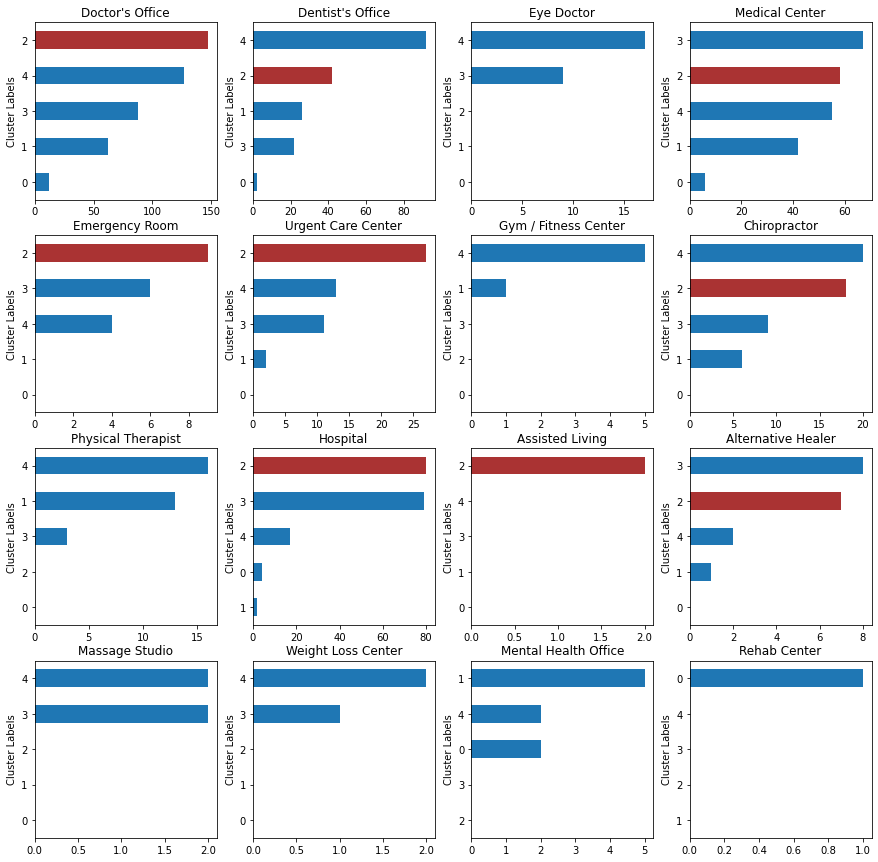

In [23]:
# create bar chart of clusters
import math
import matplotlib.pyplot as plt

def draw_barchart(dataframe, highlight_index):
    fig = plt.figure(figsize=(15, 15))
    n_rows = n_cols = math.ceil(math.sqrt(dataframe.columns.size))
    for i, col in enumerate(dataframe.columns):
        df = dataframe[[col]].sort_values(by=col)
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        df.plot.barh(ax=ax)
        pos = df.index.get_loc(highlight_index)
        ax.patches[pos].set_facecolor('#aa3333')
        ax.set_title(col)
        ax.get_legend().remove()
    plt.show()

draw_barchart(clustered[["Doctor's Office", "Dentist's Office", 'Eye Doctor',
       'Medical Center', 'Emergency Room','Urgent Care Center', 'Gym / Fitness Center', 
       'Chiropractor', 'Physical Therapist', 'Hospital',
       'Assisted Living', 'Alternative Healer', 'Massage Studio',
       'Weight Loss Center', 'Mental Health Office', 'Rehab Center']], 2)

## Results and Discussion

Based on our analysis, neighborhoods in cluster 2 have higher concentrations of hospitals, urgent care, emergency rooms, and doctor's offices. These neighborhoods will be good candidates for clients that need to be near facilities that offer emergency care services, or that can manage more serious health concerns. Therefore, the southeastern region of Honolulu county would be most ideal.

Neighborhoods in cluster 4 would be preferable for clients who still want easy access to doctor's offices, but with more emphasis on ambulatory or preventative care services, such as fitness centers, chiropractic, physical therapy, and weight management. For these clients we recommend neighborhoods within the cities of Kaneohe, Waipahu, and Mililani.

## Conclusion

The purpose of this project was to identify the best neighborhoods in Oahu for our clients to retire based on their medical needs. After collecting, analyzing, and visualizing our data, we concluded that clients who need access to more doctors, hospitals, and urgent care centers should look to reside in the southeast regions of Honolulu. Clients who do not have serious health conditions to manage, and who instead prioritize ambulatory care services, can expand their options to cities such as Kaneohe, Waipahu, and Mililani.

Further research will have to be made for clients who request for more specific specialists, such as cardiologists, oncologists, or endocrinologists. Final decisions will also be influenced by individual preferences for attributes inherent to each city/neighborhood, including population density, venues, and distance to beaches or mountains.

Limitations to consider are that the accuracy of data relies solely on that which was provided by [Foursquare Labs, Inc.](https://foursquare.com)